In [1]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import numpy as np
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    explained_variance_score
)
from scipy.stats import pearsonr
from sklearn.base import clone

def get_cols_inf(df):
    """
    Returns a list of column names that contain positive or negative infinity.
    """
    return df.columns[np.isinf(df.values).any(axis=0)].tolist()

def get_cols_zerostd(df):
    """
    Returns a list of column names with zero standard deviation (excluding NaNs).
    """
    nunique_non_nan = df.nunique(dropna=True)
    return nunique_non_nan[nunique_non_nan <= 1].index.tolist()

def get_nan_columns(df):
    """
    Returns a list of column names that contain NaN values.
    """
    return df.columns[df.isna().any()].tolist()

def plot_actual_vs_pred(y_train, y_test, y_pred, figsize=(15, 5)):
    """
    Plots actual train, test and predicted test values on a time series plot.
    Assumes all inputs are pandas Series with datetime index.
    """
    # Rename for clarity
    df_y_train = pd.DataFrame(y_train).reset_index().rename(columns={'label': "Train"})
    df_y_test = pd.DataFrame(y_test).reset_index().rename(columns={'label': "Test"})
    df_y_pred = pd.DataFrame(y_pred, index=y_test.index).reset_index().rename(columns={ 0: "Predicted"})
    # Create a combined DataFrame (aligns on index)
    df_plot = df_y_train.merge(df_y_test, on="timestamp", how = 'outer').merge(df_y_pred, on="timestamp", how='outer')
    # return df_plot
    # Plot
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(data=df_plot, x='timestamp', y='Train', label='Train', ax=ax)
    sns.lineplot(data=df_plot, x='timestamp', y='Test', label='Test', ax=ax)
    # sns.lineplot(data=df_plot, x='timestamp', y='Predicted', label='Predicted', ax=ax)
    ax.axvline(x=df_y_train['timestamp'].iloc[-1], color='gray', linestyle='--', label='Train/Test Split')
    ax.set_xlabel("Timestamp")
    ax.set_title("Actual vs Predicted Time Series")
    ax.set_ylabel("Value")
    ax.legend(loc="best")
    plt.show()

def evaluate_regression(y_true, y_pred):
    """
    Evaluates regression predictions by calculating a range of metrics.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True target values.
    y_pred : array-like of shape (n_samples,)
        Predicted target values.
    
    Returns
    -------
    dict
        Dictionary containing:
        - r2: R^2 score
        - mse: Mean Squared Error
        - rmse: Root Mean Squared Error
        - mae: Mean Absolute Error
        - mape: Mean Absolute Percentage Error
        - medae: Median Absolute Error
        - evs: Explained Variance Score
    """
    # Core metrics
    r2   = r2_score(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    
    # Additional diagnostics
    mape  = mean_absolute_percentage_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    evs   = explained_variance_score(y_true, y_pred)
    pearson = pearsonr(y_true, y_pred)[0]
    
    # Print a summary
    print("\nRegression Evaluation Metrics:")
    print(f"Pearson Correlation : {pearson:.4f}")
    print(f"R²                 : {r2:.4f}")
    print(f"MSE                : {mse:.4f}")
    print(f"RMSE               : {rmse:.4f}")
    print(f"MAE                : {mae:.4f}")
    print(f"MAPE               : {mape:.4f}")
    print(f"Median AE          : {medae:.4f}")
    print(f"Explained Variance : {evs:.4f}")
    
    return {
        'pearsonr': pearsonr,
        'r2'  : r2,
        'mse' : mse,
        'rmse': rmse,
        'mae' : mae,
        'mape': mape,
        'medae': medae,
        'evs' : evs
    }

# Tree Models 4 - Random Forest: Efficiency Optimization

- Filter Features first based on random forest

## Data Splitting

1. `sklearn_timeseries_split` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html))
   1. expanding window, rolling forward
2. `sklearn_traintest_split`
   1. fixed window
3. `walkforward_split`
   1. fixed window, rolling forward

In [2]:
from sklearn.model_selection import TimeSeriesSplit, train_test_split

def sklearn_traintest_split(X, y, test_size=0.2, **kwargs):
    return train_test_split(X, y, test_size=test_size, **kwargs)

def sklearn_timeseries_split(X, n_splits=5, **kwargs):
    tscv = TimeSeriesSplit(n_splits=n_splits, **kwargs)
    for train_idx, test_idx in tscv.split(X):
        yield train_idx, test_idx

def walkforward_split(X, initial_train_size, test_size, step_size=1):
    """
    Generator for walk-forward validation splits.

    Parameters:
    - X: pandas DataFrame or Series (indexed by time)
    - initial_train_size: int, number of initial observations for training
    - test_size: int, number of observations in each test fold
    - step_size: int, how much the train/test window shifts per iteration

    Yields:
    - (train_index, test_index): tuple of numpy arrays
    """
    n = len(X)
    train_start = 0

    for train_end in range(initial_train_size, n - test_size + 1, step_size):
        test_start = train_end
        test_end = test_start + test_size

        train_index = np.arange(train_start, train_end)
        test_index = np.arange(test_start, test_end)

        yield train_index, test_index

# Data

In [3]:
def preprocess_train(train, columns_to_drop=[]):
    df = train.copy()
    
    #### Preprocessing
    # Identify once at the start
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)
    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)
    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop all at once
    cols_to_drop = set(cols_inf) | set(cols_nan) | set(cols_zerostd)

    df = df.drop(columns=cols_to_drop)

    #### Feature Engineering

    df.loc[:, 'bidask_ratio'] = df['bid_qty'] / df['ask_qty']
    df.loc[:, 'buysell_ratio'] = np.where(df['volume'] == 0, 0, df['buy_qty'] / df['sell_qty'])
    df.loc[:, 'liqnorm_buysellratio'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] + df['sell_qty']) / df['volume'] )
    df.loc[:, 'orderflow_imbalance'] = np.where(df['volume'] == 0, 0, (df['buy_qty'] - df['sell_qty']) / (df['buy_qty'] + df['sell_qty']))

    # df.loc[:, 'buysell_ratio_shift1'] = df['buysell_ratio'].shift(-1)

    df.loc[:, 'bidask_delta'] = df['bid_qty'] - df['ask_qty']
    df.loc[:, 'buysell_delta'] = df['buy_qty'] - df['sell_qty']

    df.loc[:, 'buysell_size'] = df['buy_qty'] + df['sell_qty']
    df.loc[:, 'bidask_size'] = df['bid_qty'] + df['ask_qty']


    # Final Drop
    df = df.drop(columns=columns_to_drop)
    df = df.sort_index(ascending=True)
    return df

In [4]:
data = pd.read_parquet('kaggle/data/train.parquet')
# data = pd.read_parquet("/kaggle/input/drw-crypto-market-prediction/train.parquet")
y = data['label']
X = preprocess_train(data, columns_to_drop=['label', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty'])
X

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872']


,volume,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X889,X890,bidask_ratio,buysell_ratio,liqnorm_buysellratio,orderflow_imbalance,bidask_delta,buysell_delta,buysell_size,bidask_size
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,221.389,0.121263,-0.417690,0.005399,0.125948,0.058359,0.027359,0.035780,0.068219,1.034825,...,0.159183,0.530636,1.814006,3.921505,1.0,0.593620,6.858,131.421,221.389,23.708
2023-03-01 00:01:00,847.796,0.302841,-0.049576,0.356667,0.481087,0.237954,0.208359,0.217057,0.249624,0.948694,...,0.158963,0.530269,16.519692,1.633316,1.0,0.240501,36.254,203.896,847.796,40.926
2023-03-01 00:02:00,295.596,0.167462,-0.291212,0.083138,0.206881,0.101727,0.072778,0.081564,0.114166,0.896459,...,0.158744,0.529901,0.007336,1.167619,1.0,0.077329,-59.808,22.858,295.596,60.692
2023-03-01 00:03:00,460.705,0.072944,-0.436590,-0.102483,0.017551,0.007149,-0.021681,-0.012936,0.019634,0.732634,...,0.158524,0.529534,0.231490,2.686731,1.0,0.457514,-16.151,210.779,460.705,25.881
2023-03-01 00:04:00,142.818,0.173820,-0.213489,0.096067,0.215709,0.107133,0.078976,0.087818,0.120426,0.763537,...,0.158304,0.529167,7.869603,2.216115,1.0,0.378132,23.707,54.004,142.818,30.609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 23:55:00,94.388,0.020155,0.076565,0.228994,0.288856,0.151634,0.108347,0.088073,0.073729,0.071211,...,0.136494,0.243172,0.611756,0.705263,1.0,-0.172840,-2.642,-16.314,94.388,10.968
2024-02-29 23:56:00,177.372,0.016262,0.062527,0.214072,0.276463,0.146521,0.104164,0.084063,0.069788,0.024066,...,0.136305,0.243004,0.564317,1.640604,1.0,0.242597,-1.768,43.030,177.372,6.348
2024-02-29 23:57:00,101.252,0.045407,0.109834,0.263577,0.329266,0.174214,0.132940,0.113052,0.098865,-0.057370,...,0.136117,0.242836,1.438736,2.292427,1.0,0.392545,1.597,39.746,101.252,8.877


# Feature Selection Workflow

1. **Selection Methods**

   1. **Filter**

      - Remove irrelevant or low-variance features (e.g. identifiers, near-constant predictors)
      - Prune redundant variables via pairwise correlation or mutual information thresholds
      - Apply univariate statistical tests (ANOVA $F$, $\chi^2$, t-tests) to rank by marginal association with $y$
   2. **Feature Engineering**

      - Construct domain-driven transformations (polynomials, interactions, logs, ratios)
      - Encode categoricals, create time-series lags or rolling aggregates
      - Expand the feature space to expose nonlinear effects before reduction
   3. **Unsupervised and Dimensionality Reduction**

      - Apply PCA (or Sparse PCA) to capture 90–95 % of variance in orthogonal components
      - Optionally use ICA, autoencoders or feature agglomeration for independent or nonlinear embeddings
      - Retain either the components themselves or the original variables with highest loadings

2. **Model Evaluation**

   1. **Wrapper**

      - Forward selection: iteratively add the feature that yields the largest cross-validated performance gain
      - Backward elimination or RFE: iteratively remove the least important feature according to the model
      - Heuristic/metaheuristic searches (genetic algorithms, simulated annealing) to explore complex subset spaces
   2. **Embedded**

      - Fit penalized models (Lasso, Elastic Net) and select predictors with nonzero coefficients
      - Train tree ensembles (Random Forest, Gradient Boosting) and retain features above an importance threshold
      - Use stability selection to control false positives by combining subsampling with regularization
   3. **Feature Importance - Iterative Evaluation**

      - For each candidate subset, retrain the benchmark model and record metrics (e.g.\ $R^2$, RMSE, AUC)
      - Plot performance versus subset size to locate the "elbow" of diminishing returns
      - Compare against the full-feature baseline to quantify parsimony gains

3. **Feature Importance - Iterative Evaluation**

   1. **Retraining and metric collection.**

      Retrain your benchmark model on each candidate subset, applying $k$-fold cross-validation to compute the mean and standard deviation of key metrics (e.g.\ $R^2$, RMSE for regression; AUC, F1 for classification).

   2. **Complexity–performance analysis.**

      Plot the aggregated performance metric against subset size to reveal the trade-off curve. Identify the “elbow” where adding more features yields negligible gains, signalling an optimal balance point.
   3. **Variance and stability assessment.**

      Use bootstrapping or repeated CV to derive confidence intervals on each metric and record how often each feature is selected across folds. High inclusion frequency indicates robustness.
   4. **Parsimony quantification.**

      Measure the relative reduction in feature count versus the relative loss in performance. Optionally compute an information criterion—e.g.\\

      $$
        \mathrm{AIC}=2k - 2\ln L,\quad \mathrm{BIC}=k\ln(n) - 2\ln L
      $$

      —to formally penalize model complexity.
   5. **Final subset determination.**

      Define a tolerable performance drop (for instance, ≤ 1 % decrease in $R^2$) in exchange for parsimony gains. Confirm the chosen feature set on a held-out test set to guard against selection bias and ensure generalization.

1. **Subset Search Methods**

   * **Wrapper**: sequential forward/backward selection, recursive feature elimination (RFE), genetic algorithms or simulated annealing optimizing cross‐validated $R^2$/RMSE.
   * **Embedded**: Lasso, Elastic Net, group‐Lasso, HSIC‐Lasso for sparsity; tree ensembles (Random Forest, GBM, XGBoost) with permutation or SHAP importance thresholds; PLS‐based selection.
   * **Hybrid**: Boruta (all‐relevant), stability selection (bootstrap+regularization), consensus ranking across methods.

2. **Stability & Evaluation**
   • Retrain on each subset with $k$-fold CV to record mean ± σ of $R^2$, RMSE, MAE.
   • Plot performance vs. feature count to identify the “elbow.”
   • Compute bootstrap inclusion frequencies; prioritize features with high selection rates.
   • Apply information criteria (AIC, BIC) to penalize complexity:

   $$
     \mathrm{AIC}=2k - 2\ln L,\quad \mathrm{BIC}=k\ln(n) - 2\ln L.
   $$

   • Define an acceptable performance drop (e.g. ≤1 % in $R^2$), select minimal subset, then validate on an independent test set.

## 1.1 Selection Methods - `preprocess_train`

## 1.3 Unsupervised and Dimensionality Reduction

In [5]:
import pandas as pd
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.cluster import FeatureAgglomeration

def pca_top_features(
    X: pd.DataFrame,
    variance_threshold: float = 0.95,
    loadings_top_k: int | None = None
) -> list[str]:
    """
    Identify top features via PCA.
    If loadings_top_k is specified, return the original variables with highest absolute PCA loadings.
    Otherwise, return the names of the PCA components.
    """
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_pca = pca.fit_transform(X)
    component_names = [f'pca_{i+1}' for i in range(X_pca.shape[1])]
    
    if loadings_top_k:
        loadings = pd.DataFrame(
            pca.components_.T,
            index=X.columns,
            columns=component_names
        )
        top_vars = (
            loadings.abs()
                    .stack()
                    .sort_values(ascending=False)
                    .head(loadings_top_k)
                    .index
                    .get_level_values(0)
                    .unique()
                    .tolist()
        )
        return top_vars
    
    return component_names

def sparse_pca_top_features(
    X: pd.DataFrame,
    n_components: int = 5
) -> list[str]:
    """
    Identify features via Sparse PCA.
    Returns the names of the sparse PCA components.
    """
    spca = SparsePCA(n_components=n_components, random_state=42)
    X_spca = spca.fit_transform(X)
    return [f'spca_{i+1}' for i in range(n_components)]

def ica_top_features(
    X: pd.DataFrame,
    n_components: int = 5
) -> list[str]:
    """
    Identify features via Independent Component Analysis.
    Returns the names of the ICA components.
    """
    ica = FastICA(n_components=n_components, random_state=42)
    X_ica = ica.fit_transform(X)
    return [f'ica_{i+1}' for i in range(n_components)]

def agglomeration_top_features(
    X: pd.DataFrame,
    n_clusters: int = 5
) -> list[str]:
    """
    Identify features via Feature Agglomeration.
    Returns the names of the agglomerated feature clusters.
    """
    agglo = FeatureAgglomeration(n_clusters=n_clusters)
    X_agglo = agglo.fit_transform(X)
    return [f'agglo_{i+1}' for i in range(n_clusters)]

top_pca_features = pca_top_features(X, variance_threshold=0.95, loadings_top_k=10)
top_pca_features

['bidask_ratio',
 'volume',
 'buysell_size',
 'buysell_delta',
 'bidask_size',
 'bidask_delta',
 'X596']

In [6]:
# top_spca = sparse_pca_top_features(X, n_components=8)
# top_spca

In [7]:
# top_ica = ica_top_features(X, n_components=8)
# top_ica

In [8]:
# top_agglo = agglomeration_top_features(X, n_clusters=6)
# top_agglo

# 2 Model Training

## Data Split

In [9]:
params_split = {
    "ts1": {
        "splitter_func": sklearn_timeseries_split,
        "splitter_args": {"n_splits": 5}
    },
    # "ts2": {
    #     "splitter_func": sklearn_timeseries_split,
    #     "splitter_args": {"n_splits": 10}
    # },
    # "wf1": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 500,
    #         "test_size": 100,
    #         "step_size": 100
    #     }
    # },
    # "wf2": {
    #     "splitter_func": walk_forward_split,
    #     "splitter_args": {
    #         "initial_train_size": 1000,
    #         "test_size": 200,
    #         "step_size": 200
    #     }
    # }
}

In [10]:
# # Data 1
# start = pd.Timestamp('2023-03-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 2
# start = pd.Timestamp('2023-06-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 3
start = pd.Timestamp('2023-09-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
# start = pd.Timestamp('2023-12-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
# start = pd.Timestamp('2024-02-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

X_period = X[(X.index >= start) & (X.index <= end)]
y_period = y[(X.index >= start) & (X.index <= end)]
X_period.shape

(261428, 872)

## 2.1 Wrapper

In [11]:
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

In [12]:
def wrapper_forward_selection(model, X, y, split_fn, max_features=None, scoring=evaluate_regression):
    """
    Greedy forward feature selection using a wrapper approach and custom CV splits.

    Parameters:
    - model: an uninitialized scikit-learn regressor
    - X: pandas DataFrame of features
    - y: pandas Series or array of target
    - split_fn: function accepting X and yielding (train_idx, test_idx) tuples
    - max_features: maximum number of features to select (defaults to all)
    - scoring: function to compute error (lower is better)

    Returns:
    - selected: list of selected feature names in order of selection
    """
    selected = []
    remaining = list(X.columns)
    best_score = -np.inf
    if max_features is None:
        max_features = len(remaining)

    while len(selected) < max_features and remaining:
        feature_scores = {}
        for feat in remaining:
            current_feats = selected + [feat]
            cv_scores = []
            for train_idx, test_idx in split_fn(X):
                X_train, X_test = X.iloc[train_idx][current_feats], X.iloc[test_idx][current_feats]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                cv_scores.append(scoring(y_test, y_pred))
            feature_scores[feat] = np.mean(cv_scores)
        
        # choose the feature with the lowest mean CV error
        best_feat, feat_score = min(feature_scores.items(), key=lambda kv: kv[1])
        if feat_score < best_score:
            selected.append(best_feat)
            remaining.remove(best_feat)
            best_score = feat_score
        else:
            # no improvement -> stop
            break

    return selected

In [13]:
def wrapper_backward_elimination(model, X, y, split_fn, min_features=1, scoring=mean_squared_error):
    """
    Greedy backward elimination wrapper using custom CV splits.

    Parameters:
    - model: an uninitialized scikit-learn regressor
    - X: pandas DataFrame of features
    - y: pandas Series or array of target
    - split_fn: function accepting X and yielding (train_idx, test_idx) tuples
    - min_features: minimum number of features to retain
    - scoring: function to compute error (lower is better)

    Returns:
    - selected: list of remaining feature names after elimination
    """
    selected = list(X.columns)
    # Evaluate baseline score on all features
    def cv_score(feats):
        scores = []
        for train_idx, test_idx in split_fn(X):
            model.fit(X.iloc[train_idx][feats], y.iloc[train_idx])
            preds = model.predict(X.iloc[test_idx][feats])
            scores.append(scoring(y.iloc[test_idx], preds))
        return np.mean(scores)
    
    best_score = cv_score(selected)
    
    while len(selected) > min_features:
        feature_scores = {}
        # Try removing each feature
        for feat in selected:
            feats = [f for f in selected if f != feat]
            feature_scores[feat] = cv_score(feats)
        # Find removal that yields lowest error
        worst_feat, worst_score = min(feature_scores.items(), key=lambda kv: kv[1])
        if worst_score <= best_score:
            selected.remove(worst_feat)
            best_score = worst_score
        else:
            break  # no improvement by removing any feature
    
    return selected

In [14]:
# from sklearn.base import clone

# def treebased_optimization_featureimportance(model, X, y, split_fn, thresholds, scoring=pearson_corr):
#     """
#     Iterate through feature-importance thresholds for tree ensembles.

#     Parameters:
#     - model: an uninitialized scikit-learn tree ensemble (RF, GBM, etc.)
#     - X: pandas DataFrame of features
#     - y: pandas Series or array of target
#     - split_fn: function yielding (train_idx, test_idx) tuples
#     - thresholds: list or array of float thresholds in [0, 1]
#     - scoring: error function (lower is better)

#     Returns:
#     - dict mapping threshold -> {"features": [...], "cv_score": float}
#     """
#     # Fit on full data to obtain importances
#     fitted = clone(model).fit(X, y)
#     importances = pd.Series(fitted.feature_importances_, index=X.columns)

#     results = {}
#     for thr in thresholds:
#         selected = importances[importances >= thr].index.tolist()
#         if not selected:
#             results[thr] = {"features": [], "cv_score": None}
#             continue

#         # Evaluate CV score on selected features
#         scores = []
#         for train_idx, test_idx in split_fn(X):
#             m = clone(model)
#             m.fit(X.iloc[train_idx][selected], y.iloc[train_idx])
#             preds = m.predict(X.iloc[test_idx][selected])
#             scores.append(scoring(y.iloc[test_idx], preds))
#         results[thr] = {
#             "features": selected,
#             "cv_score": np.mean(scores)
#         }
#     return results

## 2.2 Model

In [15]:
##### Random Forest
from sklearn.ensemble import RandomForestRegressor
base_rf = RandomForestRegressor(n_estimators=100, max_depth=50, min_samples_leaf=10, random_state=42, n_jobs=-1)

# rf_space = {
#     'n_estimators':    Integer(50, 500),
#     'max_depth':       Integer(5, 50),
#     'min_samples_leaf': Integer(1, 10),
#     'max_features':    Categorical(['sqrt', 'log2', 0.1, 0.3, 0.5, 1.0]),
#     # Replace 'mse' → 'squared_error'; 'mae' → 'absolute_error'
#     'criterion':       Categorical(['squared_error', 'absolute_error'])
# }

##### XGBoost
from xgboost import XGBRegressor
base_xgb = XGBRegressor(random_state=42, n_jobs=-1)
# base_xgb = XGBRegressor(
#     tree_method='gpu_hist',
#     predictor='gpu_predictor',
#     gpu_id=0,
#     random_state=42,
# )

# xgb_space = {
#     'n_estimators': Integer(50, 500),
#     'max_depth': Integer(3, 10),
#     'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
#     'subsample': Real(0.5, 1.0),
#     'colsample_bytree': Real(0.5, 1.0),
#     'gamma': Real(0, 5)
# }

##### LightGBM
from lightgbm import LGBMRegressor
base_lgb = LGBMRegressor(random_state=42, n_jobs=-1,)
# base_lgb = LGBMRegressor(
#     device='gpu',
#     gpu_platform_id=0,   # usually 0 if you have a single GPU
#     gpu_device_id=0,
#     random_state=42,
# )

# lgb_space = {
#     'n_estimators': Integer(50, 500),
#     'max_depth': Integer(3, 15),
#     'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
#     'num_leaves': Integer(20, 150),
#     'subsample': Real(0.5, 1.0),
#     'colsample_bytree': Real(0.5, 1.0),
#     'reg_alpha': Real(0, 5),
#     'reg_lambda': Real(0, 5)
# }

##### CatBoost
from catboost import CatBoostRegressor
base_cat = CatBoostRegressor(random_state=42, verbose=1)
# base_cat = CatBoostRegressor(
#     task_type='GPU',
#     devices='0',        # which GPU; use ‘0’ if you have a single GPU
#     random_state=42,
#     verbose=0,
# )

# cat_space = {
#     'iterations': Integer(50, 500),
#     'depth': Integer(3, 10),
#     'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
#     'l2_leaf_reg': Real(1, 10),
#     'bagging_temperature': Real(0, 1)
# }

##### Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
base_gb = GradientBoostingRegressor(random_state=42)
# gb_space = {
#     'n_estimators': Integer(50, 500),
#     'max_depth': Integer(3, 10),
#     'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
#     'subsample': Real(0.5, 1.0),
#     'min_samples_leaf': Integer(1, 10)
# }

## 2.3 Feature Importance

# 3 Model Training

In [16]:
# # Data 1
# start = pd.Timestamp('2023-03-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 2
# start = pd.Timestamp('2023-06-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# # Data 3
# start = pd.Timestamp('2023-09-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
# start = pd.Timestamp('2023-12-01 00:00:00')
# end = pd.Timestamp('2024-02-29 23:59:00')

# Data 4
start = pd.Timestamp('2024-02-01 00:00:00')
end = pd.Timestamp('2024-02-29 23:59:00')

X_period = X[(X.index >= start) & (X.index <= end)]
y_period = y[(X.index >= start) & (X.index <= end)]
X_period.shape

(41737, 872)

## Simple Train Test Split

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_period, y_period, test_size=0.5, random_state=42, shuffle = False)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (20868, 872), Test shape: (20869, 872)



Regression Evaluation Metrics:
Pearson Correlation : 0.0234
R²                 : -0.0098
MSE                : 1.3270
RMSE               : 1.1519
MAE                : 0.7897
MAPE               : 2.7241
Median AE          : 0.5584
Explained Variance : -0.0074


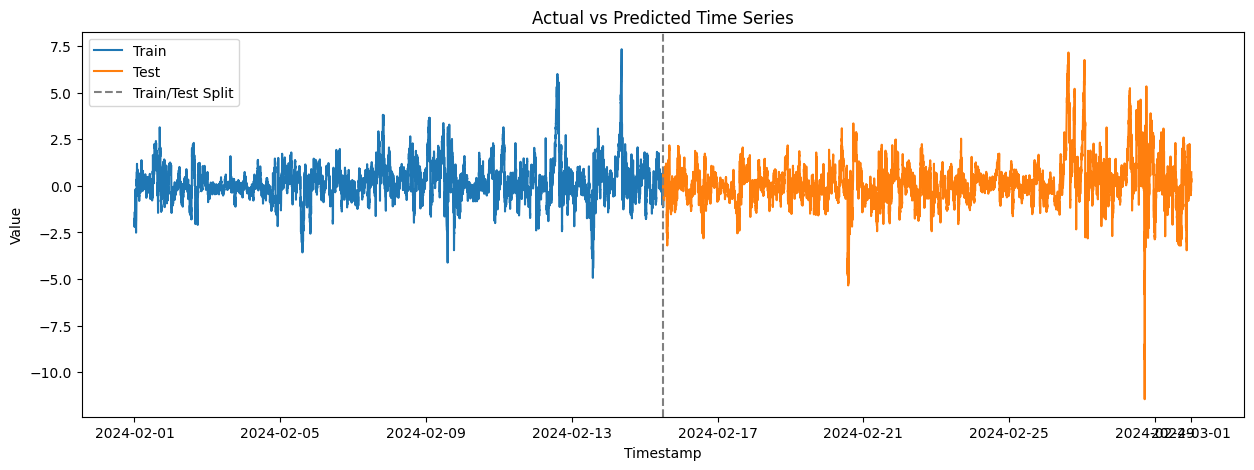

In [18]:
from sklearn.linear_model import Lasso

base_lasso = Lasso(alpha=0.1, max_iter=100000, random_state=42, fit_intercept=True)
base_lasso.fit(X_train, y_train)
y_pred = base_lasso.predict(X_test)
results = evaluate_regression(y_test, y_pred)
plot_actual_vs_pred(y_train, y_test, y_pred)

## Tree Based Iterative Feature Elimination

In scikit-learn, for tree-based models like `DecisionTree`, `RandomForest`, and `GradientBoosting`, **feature importance** is calculated based on the **total reduction in impurity (e.g. Gini, entropy, MSE)** brought by each feature across all trees.

**Formula (Mean Decrease in Impurity):**

For a feature $j$, its importance is:

$$
\text{FI}(j) = \sum_{t \in T} \sum_{n \in N_t} \mathbb{1}_{\{f(n) = j\}} \cdot \Delta i(n) \cdot \frac{w(n)}{W}
$$

Where:

* $T$ is the set of all trees (only for ensembles).
* $N_t$ is the set of non-leaf nodes in tree $t$.
* $f(n)$ is the feature used to split node $n$.
* $\Delta i(n)$ is the impurity decrease at node $n$.
* $w(n)$ is the weighted number of samples reaching node $n$.
* $W$ is the total number of samples across the tree (or forest).

In [ ]:
def treebased_iterative_feature_elimination(models, X, y, split_fn, drop_fraction=0.1, min_features=5, scoring=None):
    """
    Iteratively eliminate least important features using tree-based models.

    Parameters
    ----------
    models : list of sklearn estimators
        List of uninitialized tree-based models with `feature_importances_` attribute.
    X : pd.DataFrame
        Input feature matrix.
    y : pd.Series or np.ndarray
        Target variable.
    split_fn : function
        Generator yielding (train_idx, test_idx) splits.
    drop_fraction : float
        Fraction of lowest-importance features to remove at each iteration.
    min_features : int
        Stop once number of features ≤ min_features.
    scoring : callable
        Scoring function: scoring(y_true, y_pred) → float

    Returns
    -------
    dict
        Nested dictionary: model_name → list of result dicts, each containing
        {
            "iteration": int,
            "features": list[str],
            "cv_score_mean": float,
            "num_features": int
        }
    """
    results = []
    splits = list(split_fn(X))
    n_splits = len(splits)

    for model in models:
        model_name = model.__class__.__name__
        print(f"\n[*] Starting elimination with model: {model_name}")
        current_X = X.copy()
        iteration = 0

        while current_X.shape[1] > min_features:
            iteration += 1
            print(f"\n[+] Iteration {iteration} - {current_X.shape[1]} features")

            # Fit model and get importances
            m = clone(model)
            m.fit(current_X, y)
            importances = pd.Series(m.feature_importances_, index=current_X.columns)

            # Evaluate with cross-validation
            scores = []
            for i, (train_idx, test_idx) in enumerate(splits, start=1):
                print(f"    [Fold {i}/{n_splits}] ...", end="\r")
                m_cv = clone(model)
                m_cv.fit(current_X.iloc[train_idx], y.iloc[train_idx])
                preds = m_cv.predict(current_X.iloc[test_idx])
                scores.append(scoring(y.iloc[test_idx], preds))
            mean_score = np.mean(scores)
            print(f"    → Mean score: {mean_score:.4f}")

            results.append({
                "model": model_name,
                "iteration": iteration,
                "num_features": current_X.shape[1],
                "features": current_X.columns.tolist(),
                "cv_score_mean": mean_score
            })
            # Drop bottom `drop_fraction` of features
            n_drop = max(10, int(len(importances) * drop_fraction))
            least_important = importances.nsmallest(n_drop).index
            current_X = current_X.drop(columns=least_important)

        print(f"[*] Stopping: {current_X.shape[1]} features remaining (≤ min_features={min_features})")

    return results

In [ ]:
# Base Random Forest
base_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=50,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

# Gradient Boosting (scikit-learn)
base_gbm = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=50,
    min_samples_leaf=10,
    random_state=42
)

# XGBoost
base_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=50,
    min_child_weight=10,  # closest to min_samples_leaf
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# LightGBM
base_lgbm = LGBMRegressor(
    n_estimators=100,
    max_depth=50,
    min_child_samples=10,  # equivalent to min_samples_leaf
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# CatBoost
base_cat = CatBoostRegressor(
    iterations=100,
    depth=50,
    random_seed=42,
    verbose=False
)


[*] Starting elimination with model: RandomForestRegressor

[+] Iteration 1 - 872 features
    → Mean score: -0.0239

[+] Iteration 2 - 785 features
    → Mean score: -0.0248

[+] Iteration 3 - 707 features
    → Mean score: -0.0248

[+] Iteration 4 - 637 features
    → Mean score: -0.0276

[+] Iteration 5 - 574 features
    → Mean score: -0.0252

[+] Iteration 6 - 517 features
    → Mean score: -0.0229

[+] Iteration 7 - 466 features
    → Mean score: -0.0217

[+] Iteration 8 - 420 features
    → Mean score: -0.0222

[+] Iteration 9 - 378 features
    → Mean score: -0.0316

[+] Iteration 10 - 341 features
    → Mean score: -0.0255

[+] Iteration 11 - 307 features
    → Mean score: -0.0206

[+] Iteration 12 - 277 features
    → Mean score: -0.0271

[+] Iteration 13 - 250 features
    → Mean score: -0.0549

[+] Iteration 14 - 225 features
    → Mean score: -0.0408

[+] Iteration 15 - 203 features
    → Mean score: -0.0418

[+] Iteration 16 - 183 features
    → Mean score: -0.0421

[+] 

In [ ]:
models = [
    base_rf,
    base_gbm,
    base_xgb,
    base_lgbm,
    base_cat
]

results = treebased_iterative_feature_elimination(
    models=models,
    X=X_period,
    y=y_period,
    split_fn=lambda X: sklearn_timeseries_split(X, n_splits=2),
    drop_fraction=0.3,
    min_features=50,
    scoring=lambda y_true, y_pred: np.corrcoef(y_true, y_pred)[0, 1]  # Pearson
)

In [ ]:
results_df = pd.DataFrame(results).sort_values('cv_score_mean', ascending=False)
results_df

,iteration,num_features,features,cv_score_mean,model
29,30,19,"[X35, X96, X113, X124, X126, X175, X179, X261,...",0.005552,RandomForestRegressor
25,26,59,"[X35, X88, X96, X97, X113, X123, X124, X126, X...",-0.017137,RandomForestRegressor
18,19,135,"[X16, X33, X34, X35, X38, X83, X84, X88, X91, ...",-0.018319,RandomForestRegressor
28,29,29,"[X35, X96, X113, X124, X126, X175, X179, X198,...",-0.018876,RandomForestRegressor
24,25,69,"[X35, X88, X96, X97, X98, X113, X123, X124, X1...",-0.019023,RandomForestRegressor
10,11,307,"[X9, X16, X17, X21, X25, X33, X34, X35, X36, X...",-0.020626,RandomForestRegressor
17,18,149,"[X16, X33, X34, X35, X38, X74, X83, X84, X88, ...",-0.020722,RandomForestRegressor
6,7,466,"[X7, X9, X13, X15, X16, X17, X21, X23, X24, X2...",-0.021745,RandomForestRegressor
7,8,420,"[X7, X9, X13, X15, X16, X17, X21, X24, X25, X3...",-0.022214,RandomForestRegressor
5,6,517,"[X1, X7, X9, X13, X14, X15, X16, X17, X21, X22...",-0.022918,RandomForestRegressor


In [ ]:
results_df.to_csv('./optimization/iterative_fe_3.csv', index=False)